# MNIST

In [1]:
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
%matplotlib inline
import pdb

### Load Data

In [2]:
trainMAT = sio.loadmat('./mnist/train.mat')
testMAT = sio.loadmat('./mnist/test.mat')
trainX = trainMAT["trainX"]
trainY = trainX[:, -1:].reshape(1, len(trainX))[0]
np.random.shuffle(trainX)
validate_data = trainX[:10000, :]
train_data = trainX[10000:, :]
test_data = testMAT["testX"]
CLASS_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
c = 0.0001

## a) Fit Gaussian Distribution to each digit class using MLE

In [3]:
def gaussian_mean_cov(data, label, if_print=False):
    df = pd.DataFrame(data)
    df = df[df[784]== label]
    features = normalize(df.values[:, :-1].astype(np.float32))
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=0)
    if if_print:
        print("Label ", label, " : ")
        print("Mu = ", mu)
        print("Sigma = ", sigma, "\n")
    return mu, sigma

## b) Visualize covariance matrix

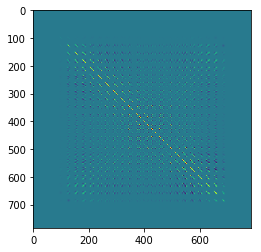

In [4]:
plt.imshow(gaussian_mean_cov(train_data, 0)[1])

Observation:   
1. the values on one diagonal are comparably large. These values are the variances of the RVs, so it's reasonable that they are larger than any feature pair's covariance  
2. There are parts of the values super small (the faded color on the graph), which means the features involved don't have much dependency on each other, or they might be always 0 (no color on this pixel)

## c) LDA & QDA

In [15]:
def lda_train(data):
    models = dict()
    x = normalize(data[:, :-1].astype(np.float32))
    sigma = np.cov(x, rowvar=0)
    for label in CLASS_:
        mu, _ = gaussian_mean_cov(data, label)
        m = multivariate_normal(mu, sigma + c * np.identity(sigma.shape[0]))
        models[label] = m
    return models


def qda_train(data):
    models = dict()
    for label in CLASS_:
        mu, sigma = gaussian_mean_cov(data, label)
        m = multivariate_normal(mu, sigma + c * np.identity(sigma.shape[0]))
        models[label] = m
    return models
    

def test(x, models):
    y = list()
    x = normalize(x.astype(np.float32))
    for sample in x:
        prob = [models[label].logpdf(sample) + compute_prior(trainY, label) for label in CLASS_]
        y.append(np.argmax(prob))
    return y


def batch_train_and_evaluate(train_data, validate_data, categories, type="LDA"):
    errors = []
    for size in categories:
        models = qda_train(train_data[:size, :])
        if type == "LDA":
            models = lda_train(train_data[:size, :])
        prediction = test(validate_data[:, :-1], models)
        y = validate_data[:, -1:].reshape(1, len(validate_data))[0]
        err = 1 - np.mean(np.equal(prediction, y).astype(np.int32))
        errors.append(err)
        print("Error for training size {}: {}".format(size, err))
    
    plt.plot(categories, errors, 'ro')
    plt.axis([min(categories)-10, max(categories)+10, -0.1, max(errors)+0.1])
    plt.title("{} Error rate".format(type)) 
    return models

def compute_prior(data, label):
    return np.mean(np.equal(data, label).astype(np.int32))



Error for training size 100: 0.35419999999999996
Error for training size 200: 0.2751
Error for training size 500: 0.22060000000000002
Error for training size 1000: 0.18779999999999997
Error for training size 2000: 0.16559999999999997
Error for training size 5000: 0.14970000000000006
Error for training size 10000: 0.14370000000000005
Error for training size 30000: 0.14
Error for training size 50000: 0.1392


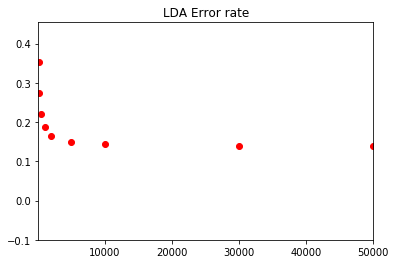

In [16]:
# Train and Error
categories = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
lda_models = batch_train_and_evaluate(train_data, validate_data, categories)

Error for training size 100: 0.2723
Error for training size 200: 0.14900000000000002
Error for training size 500: 0.09509999999999996
Error for training size 1000: 0.07779999999999998
Error for training size 2000: 0.06340000000000001
Error for training size 5000: 0.062000000000000055
Error for training size 10000: 0.05900000000000005
Error for training size 30000: 0.05930000000000002
Error for training size 50000: 0.05810000000000004


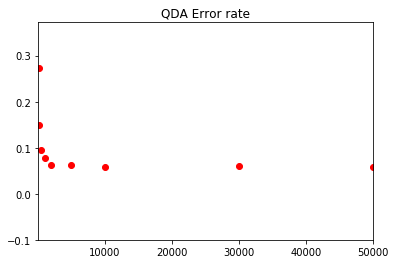

In [17]:
qda_models = batch_train_and_evaluate(train_data, validate_data, categories, type="QDA")

In [9]:
# Test
lda_y = test(test_data, lda_models)
qda_y = test(test_data, qda_models)

## c) LDA vs QDA
QDA is better. Because we have 10 classes in this problem, but LDA uses the same variance for all their distributions, which isn't reasonable because different class random variable might have very different variance. 

In [21]:
df = pd.DataFrame(data = qda_y, columns=["Category"]) 
df.index.name = "Id"
df.to_csv("./mnist.csv")

### Kaggle: 0.95640